In [1]:
from utils.getter import *
import torchvision

In [ ]:
device = torch.device('cuda')

In [2]:
transforms = Compose([
 #   Resize((300,300)),
    ToTensor(),
    #Normalize(),
])

In [3]:
img_path = "datasets/datasets/Velastin/images"
anno_path = {
    "train": "datasets/datasets/Velastin/annotations/velastin_train.json",
    "val": "datasets/datasets/Velastin/annotations/velastin_val.json"}

trainset = ObjectDetectionDataset(img_dir=img_path, ann_path = anno_path['train'],transforms= transforms)
valset = ObjectDetectionDataset(img_dir=img_path, ann_path = anno_path['val'],transforms= transforms)
NUM_CLASSES = len(trainset.classes)
print(trainset)
print(valset)

Custom Dataset for Object Detection
-------------------------------
Number of samples: 8000
Number of classes: 3

Custom Dataset for Object Detection
-------------------------------
Number of samples: 2000
Number of classes: 3



In [30]:
print(trainset.annos['annotations'][-1])

{'area': 0, 'bbox': [240, 105, 15, 25], 'category_id': 1, 'id': 41503, 'ignore': 0, 'image_id': '009999', 'iscrowd': 0, 'obj_id': 317, 'segmentation': []}


In [ ]:
trainset.visualize_item(0)

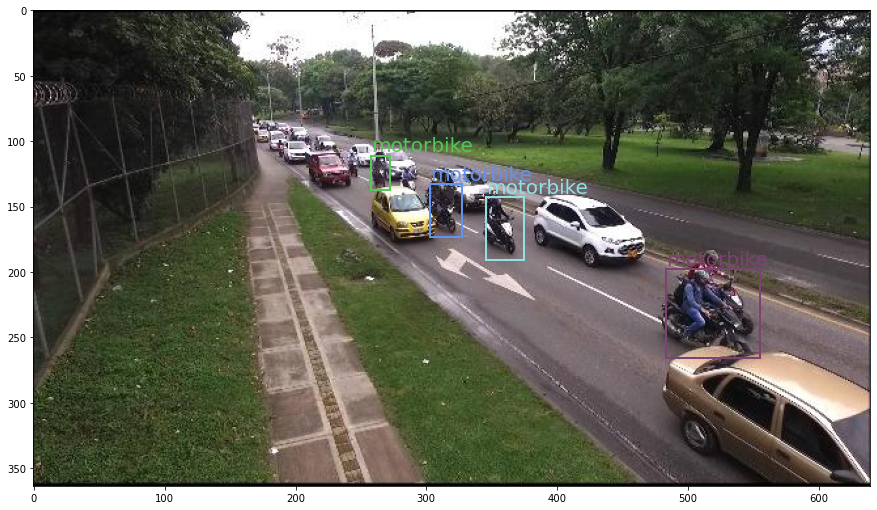

In [28]:
item = trainset[7]
img_tensor = item['img']
img = torchvision.transforms.transforms.ToPILImage(mode='RGB')(img_tensor)
boxes = item['box'].numpy()
labels = item['label'].numpy()
trainset.visualize(img,boxes, labels)

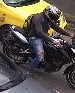

In [16]:
img_crop = torchvision.transforms.transforms.ToPILImage(mode='RGB')(roi)
display(img_crop)

In [15]:
import numpy as np
box = [int(i) for i in boxes[0]]
x,y,w,h = box
roi = img_tensor[:, y:y+h, x:x+w]
print(roi)

tensor([[[0.9333, 1.0000, 0.7608,  ..., 0.3255, 0.3176, 0.3098],
         [0.9294, 0.9647, 0.9725,  ..., 0.3451, 0.3333, 0.3255],
         [0.9216, 0.8588, 1.0000,  ..., 0.3451, 0.3373, 0.3333],
         ...,
         [0.1843, 0.1412, 0.1216,  ..., 0.2863, 0.2941, 0.2118],
         [0.0980, 0.1686, 0.5373,  ..., 0.3490, 0.3176, 0.3922],
         [0.8235, 0.8196, 0.7608,  ..., 0.3608, 0.3608, 0.3608]],

        [[0.8941, 1.0000, 0.7529,  ..., 0.2863, 0.2784, 0.2706],
         [0.8824, 0.9373, 0.9686,  ..., 0.3059, 0.2941, 0.2863],
         [0.8667, 0.8314, 1.0000,  ..., 0.3059, 0.2980, 0.2941],
         ...,
         [0.1569, 0.1255, 0.1059,  ..., 0.2627, 0.2706, 0.1882],
         [0.0824, 0.1529, 0.5216,  ..., 0.3255, 0.2941, 0.3686],
         [0.8078, 0.8039, 0.7451,  ..., 0.3255, 0.3373, 0.3373]],

        [[0.6863, 0.8039, 0.5608,  ..., 0.2902, 0.2824, 0.2745],
         [0.6471, 0.6706, 0.7059,  ..., 0.3098, 0.2980, 0.2902],
         [0.6196, 0.5255, 0.6863,  ..., 0.3098, 0.3020, 0.

In [10]:
print(x,y,w,h)

563.0 204.0 75.0 93.0


In [ ]:
img, box, label = trainset.denormalize()

In [ ]:
img, box, label = trainset[0].values()

In [ ]:
outs = trainset.transforms.denormalize(img=img,box=box,label=label)
print(outs['box'])

In [ ]:
BATCH_SIZE = 4
my_collate = RetinaNetCollator() #trainset.collate_fn, valset.collate_fn
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=my_collate, shuffle=True)
valloader = data.DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=my_collate, shuffle=False)

In [ ]:
t = my_collate.encoder._get_anchor_boxes(torch.Tensor([300,300]))
print(t.shape)

In [ ]:
from models.ssd.model import *

In [ ]:
SSD = SSD300(n_classes=20)

In [ ]:
for b in trainloader:
    imgs = b['imgs'].to(device)
    lbls = b['labels'].to(device)
    boxes = b['boxes'].to(device)
    break

In [ ]:
print(imgs.shape)
print(lbls.shape)
print(boxes.shape)

In [ ]:
outputs = net(imgs)

In [ ]:
loc_preds, cls_preds = outputs
print(boxes.shape)
print(lbls.shape)
print(loc_preds.shape) 
print(cls_preds.shape)

In [ ]:
print(lbls[1])

In [ ]:
loss = criterion(loc_preds, cls_preds, boxes, lbls)
# loc, cls
print(loss[0].item(), loss[1].item())

In [ ]:
encoder = DataEncoder()

In [ ]:
for loc,cls in zip(loc_preds, cls_preds):
    outputs = encoder.decode(loc, cls, input_size=(300,300))
    break
boxes, labels, scores = outputs
print(boxes.shape)
print(labels.shape)
print(scores.shape)

In [ ]:
import torch

In [ ]:
def change_box_order(boxes, order):
    """
    Change box order between (xmin, ymin, xmax, ymax) and (xcenter, ycenter, width, height).
    :param boxes: (tensor) bounding boxes, sized [N, 4]
    :param order: (str) either 'xyxy2xywh' or 'xywh2xyxy'.
    :return: (tensor) converted bounding boxes, size [N, 4]
    """
    assert order in ['xyxy2xywh', 'xywh2xyxy']
    a = boxes[:, :2]
    b = boxes[:, 2:]
    if order == 'xyxy2xywh':
        return torch.cat([(a + b) / 2., b - a], 1)
    return torch.cat([a - b / 2., a + b / 2.], 1)

In [ ]:
num_box = 20000
boxes1 = torch.randint(0,100,(num_box,4))
boxes2 = torch.randint(0,100,(num_box,4))
print(boxes1.shape)
print(boxes2.shape)

In [ ]:
xy_boxes1 = change_box_order(boxes1, 'xywh2xyxy')
xy_boxes2 = change_box_order(boxes2, 'xywh2xyxy')
print(xy_boxes1.shape)
print(xy_boxes2.shape)

In [ ]:
def box_iou(box1, box2, order='xyxy'):
    """
    Compute the intersection over union of two set of boxes.
    The default box order is (xmin, ymin, xmax, ymax).
    :param box1: (tensor) bounding boxes, sized [N, 4]
    :param box2: (tensor) bounding boxes, sized [M, 4].
    :param order: (str) box order, either 'xyxy' or 'xywh'
    :return: (tensor) iou, sized [N, M]
    """
    if order == 'xywh':
        box1 = change_box_order(box1, 'xywh2xyxy')
        box2 = change_box_order(box2, 'xywh2xyxy')

    N = box1.size(0)
    M = box2.size(0)

    lt = torch.max(box1[:, None, :2], box2[:, :2])  # [N, M, 2]
    rb = torch.min(box1[:, None, 2:], box2[:, 2:])  # [N, M, 2]

    wh = (rb - lt).clamp(min=0)  # [N, M, 2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N, M]

    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])  # [N,]
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])  # [N.]
    iou = inter / (area1[:, None] + area2 - inter)
    return iou

In [ ]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

In [ ]:
import time

In [ ]:
start_time = time.time()
iou2 = box_iou(xy_boxes1, xy_boxes2)
print("--- %s seconds ---" % (time.time() - start_time))
print(iou2)

In [ ]:
start_time = time.time()
iou1 = find_jaccard_overlap(xy_boxes1, xy_boxes2)
print("--- %s seconds ---" % (time.time() - start_time))
print(iou1)
